<a href="https://colab.research.google.com/github/ping-Mel/ERV-V2-Assignments/blob/main/session8/s8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Models:
    """
    In this class, we organize our neural network architectures as nested/inner classes.
    This approach groups related functionalities and creates an organized and encapsulated
    code structure. Each neural network architecture is defined as an inner class within
    this Models class. This allows for easy instantiation and clear hierarchy of neural
    network models, each with its distinct architecture and characteristics.
    """
    @staticmethod
    def evaluate_model(model_class, input_size=(3, 32, 32)):
        """
        Static method to evaluate the model architecture.
        This method will print a summary of the model showing the layers and parameters.

        Parameters:
        model_class (class): The inner class representing the neural network architecture to evaluate.
        input_size (tuple): The size of the input to the model. Default is (1, 28, 28) for MNIST dataset.
        """
        # Check for CUDA availability and set the device accordingly
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

        # Initialize the model from the inner class and move to the appropriate device
        model = model_class().to(device)

        # Print the summary of the model
        summary(model, input_size=input_size)



    class NetA(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetA, self).__init__()
            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #
            self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #
            self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5    28      1   2    6      14     2    0  2
            self.conv3 = nn.Conv2d(64, 64, kernel_size=1)

            self.pool1 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #
            self.conv4 = nn.Conv2d(64, 128, 3,padding=1)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #
            self.conv5 = nn.Conv2d(128, 32, 3,padding=1)
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 24    5     4    1    32     3     4     0  3
            self.conv6 = nn.Conv2d(32, 32, 3,padding=1)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 32    3      4   1    40     1     4     0  3
            self.conv7 = nn.Conv2d(32, 32, 1)
            self.pool2 = nn.MaxPool2d(2, 2)

            self.conv8 = nn.Conv2d(32, 32, 3,padding=1)
            self.conv9 = nn.Conv2d(32, 32, 3,padding=1)
            self.conv10 = nn.Conv2d(32, 64, 3,padding=1)
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            self.conv11 = nn.Conv2d(64, 10, 1)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))  # 1x1 conv
            x = self.pool1(x)

            x = F.relu(self.conv4(x))
            x = F.relu(self.conv5(x))
            x = F.relu(self.conv6(x))
            x = F.relu(self.conv7(x))  # 1x1 conv
            x = self.pool2(x)

            x = F.relu(self.conv8(x))
            x = F.relu(self.conv9(x))
            x = F.relu(self.conv10(x))

            x = self.global_avg_pool(x)
            x = self.conv11(x)  # Final 1x1 conv

            # Flatten for the final output
            x = x.view(x.size(0), -1)
            return F.log_softmax(x, dim=-1)

# Target 1: Group Normalisation Network

## Initial Setup
- Construct the **basic skeleton** of the neural network model. This includes defining the layers and forward pass logic in Class Models (model.py) NetA inner class.
-

## Aim
1.   **70%** (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to **20** Epochs
3.   Less than **50k** Parameters

In [2]:
!pip install torchsummary

from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.49139968, 0.48215827, 0.44653124)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.49139968, 0.48215827, 0.44653124))
                                       ])

In [4]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [01:37<00:00, 1741386.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


In [13]:
Models.evaluate_model(Models.NetA)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
            Conv2d-2           [-1, 64, 32, 32]          18,496
            Conv2d-3           [-1, 64, 32, 32]           4,160
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
            Conv2d-6           [-1, 32, 16, 16]          18,464
            Conv2d-7           [-1, 32, 16, 16]           9,248
            Conv2d-8           [-1, 32, 16, 16]           1,056
         MaxPool2d-9             [-1, 32, 8, 8]               0
           Conv2d-10             [-1, 32, 8, 8]           9,248
           Conv2d-11             [-1, 32, 8, 8]           9,248
           Conv2d-12             [-1, 32, 8, 8]           9,248
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Conv2d-14             [-1, 1

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Models.NetA().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3039493560791016 Batch_id=195 Accuracy=10.02%: 100%|██████████| 196/196 [00:15<00:00, 12.32it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


Loss=2.3033273220062256 Batch_id=195 Accuracy=9.78%: 100%|██████████| 196/196 [00:15<00:00, 12.69it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 2


Loss=2.3018083572387695 Batch_id=195 Accuracy=9.91%: 100%|██████████| 196/196 [00:16<00:00, 12.24it/s]



Test set: Average loss: 2.3027, Accuracy: 1000/10000 (10.00%)

EPOCH: 3


Loss=2.3038604259490967 Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:16<00:00, 11.93it/s]



Test set: Average loss: 2.3027, Accuracy: 1000/10000 (10.00%)

EPOCH: 4


Loss=2.3024845123291016 Batch_id=195 Accuracy=9.56%: 100%|██████████| 196/196 [00:15<00:00, 12.49it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 5


Loss=2.301051139831543 Batch_id=195 Accuracy=9.73%: 100%|██████████| 196/196 [00:15<00:00, 12.68it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 6


Loss=2.3031704425811768 Batch_id=195 Accuracy=9.76%: 100%|██████████| 196/196 [00:15<00:00, 12.79it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 7


Loss=2.301490068435669 Batch_id=195 Accuracy=9.91%: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 8


Loss=2.301427125930786 Batch_id=195 Accuracy=9.85%: 100%|██████████| 196/196 [00:15<00:00, 12.97it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 9


Loss=2.3018012046813965 Batch_id=195 Accuracy=9.95%: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 10


Loss=2.302487850189209 Batch_id=195 Accuracy=10.00%: 100%|██████████| 196/196 [00:15<00:00, 12.96it/s]



Test set: Average loss: 2.3027, Accuracy: 1000/10000 (10.00%)

EPOCH: 11


Loss=2.302832841873169 Batch_id=195 Accuracy=9.88%: 100%|██████████| 196/196 [00:15<00:00, 12.37it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 12


Loss=2.304283618927002 Batch_id=195 Accuracy=9.66%: 100%|██████████| 196/196 [00:15<00:00, 12.83it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 13


Loss=2.3025591373443604 Batch_id=195 Accuracy=9.95%: 100%|██████████| 196/196 [00:15<00:00, 13.01it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 14


Loss=2.302042007446289 Batch_id=195 Accuracy=9.80%: 100%|██████████| 196/196 [00:15<00:00, 12.38it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 15


Loss=2.3032569885253906 Batch_id=195 Accuracy=9.85%: 100%|██████████| 196/196 [00:15<00:00, 12.71it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 16


Loss=2.3022494316101074 Batch_id=195 Accuracy=9.81%: 100%|██████████| 196/196 [00:16<00:00, 11.97it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 17


Loss=2.3008275032043457 Batch_id=195 Accuracy=9.89%: 100%|██████████| 196/196 [00:15<00:00, 12.86it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 18


Loss=2.3024768829345703 Batch_id=195 Accuracy=9.88%: 100%|██████████| 196/196 [00:15<00:00, 12.74it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)

EPOCH: 19


Loss=2.3026230335235596 Batch_id=195 Accuracy=9.90%: 100%|██████████| 196/196 [00:15<00:00, 12.35it/s]



Test set: Average loss: 2.3026, Accuracy: 1000/10000 (10.00%)



Text(0.5, 1.0, 'Test Accuracy')

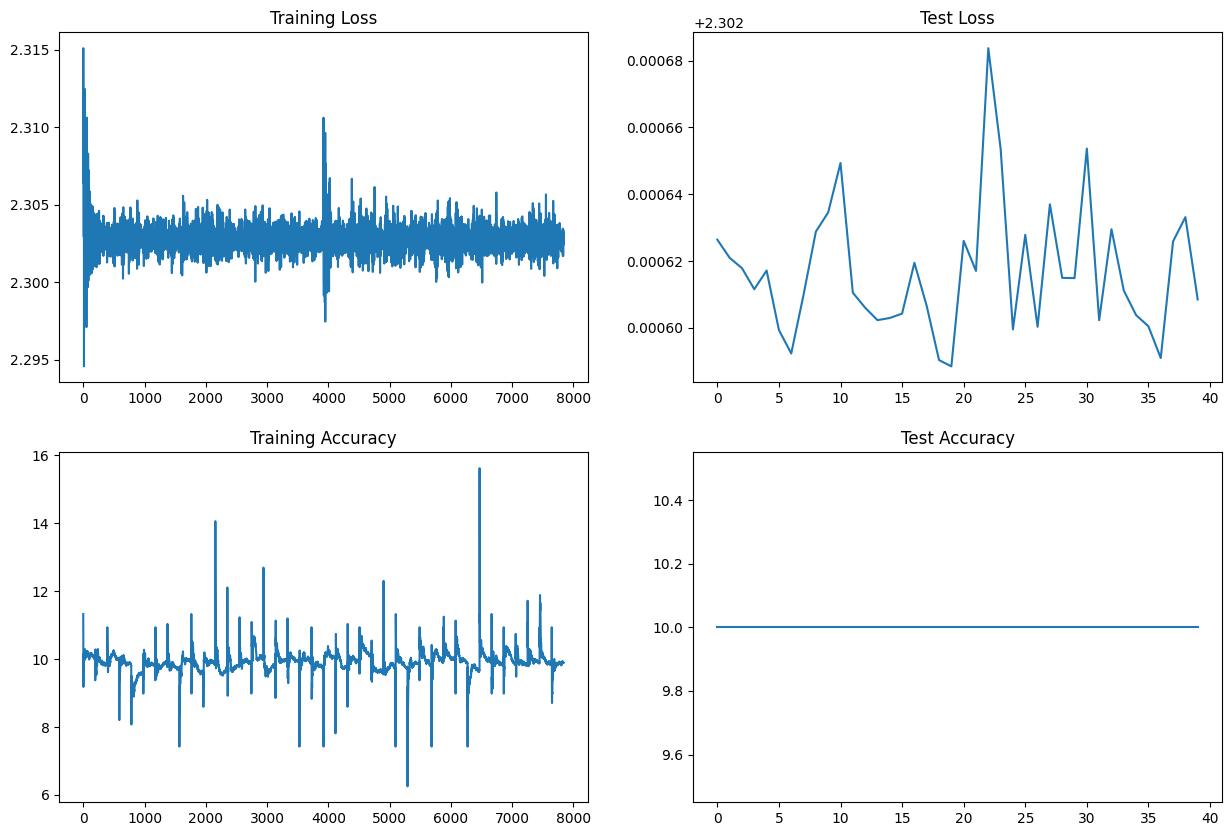

In [19]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")